# MA934  Numerical Methods - class worksheet 3 (not assessed)

## Structural recursion and Gillespie algorithm

You might need to install some packages the first time you run this notebook:

In [2]:
# using Pkg
# # Pkg.add("Plots")
# Pkg.add("PyPlot")
# Pkg.add("PyCall")
#Pkg.add("LaTeXStrings")

In [3]:
using Revise
using Plots
pyplot()

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278


Plots.PyPlotBackend()

## Some background on how to use the sample code

The custom module MA934.jl defines some useful data structures and some functions that operate on them. You should familiarise yourself with how Julia modules are structured and structure your own code accordingly.

The composite type **KeyValuePair** defines a simple data structure to represent an (**Int64**, **Float64**) key-value pair. 

The recursive type **LinkedList** defines a linked list that stores a **KeyValuePair** at each node. 

The recursive type **FTree** defines a Fenwick tree that stores a **KeyValuePair** at each leaf node.

Many languages have a keyword NULL which can be assigned to an object to indicate that it has not yet been initialised. Julia does not have this feature: accessing an object that has not yet been initialised throws an error. On the other hand, Julia does have a **Nothing** type which represents an object with no fields. This is not quite the same thing however: an object of type **LinkedList**, for example, cannot be assigned a value of type **Nothing**.

Recursive data structures often use an uninitialised object to denote the end of a list, a leaf of a tree etc. This is a problem in Julia: if an object is uninitialised you cannot access it to check whether it is initialised without throwing an error. One work around for situations where a value x of type **T** exists only sometimes, the **Union{T, Nothing}** type can be used for function arguments, object fields and array element types. This approach is adopted in the MA934.jl module. More information can be found at https://docs.julialang.org/en/v1/manual/faq/#faq-nothing-1

The function 

> MA934.buildlist(dataArray::Array{KeyValuePair, 1})

takes an array of **KeyValuePair** objects as input and returns a **LinkedList** containing these **KeyValuePair**s. The following sample code illustrates how to use the **LinkedList** data type.

In [31]:
using Random
# To use custom modules, we need to tell Julia where to find the source files. In this case, they are in
# the current working directory:
push!(LOAD_PATH, pwd())
using StructuralRecursion

# Create some key-value pairs. The KeyValuePair data type is a struct. Instances of
# structs in Julia can be created by assigning values to their fields as follows:
k1 = StructuralRecursion.KeyValuePair(1,3.141592)
k2 = StructuralRecursion.KeyValuePair(2,2.718281)
# The prefix MA934 indicates that the data type KeyValuePair is defined in the module MA934. This
# is not necessary however because the module file MA934.jl "exports" the definition. Hence we can
# also write:
k3 = KeyValuePair(3,1.414213)

# The LinkedList data type is also a struct. We can create a new instance
# simply by assigning appropriate values to its fields as for any
# other struct:
L1 = LinkedList(k1, Nothing())
println(L1)

# Key-value pairs can be appended to the list:
L1 = StructuralRecursion.append(L1, k2)
println(L1)

# Key-value pairs can also be prepended to the list:
L1 = StructuralRecursion.prepend(L1, k3)
println(L1)

# We can also create a list using the build function by passing it an array of key-value pairs:
# First we need to create an array. We will use a random number generator to generate random values.

# The random number generator is initialised with a seed - 1234 in this case. A random number generator
# initialised with the same seed will always produced exactly the same sequence of numbers
rng = MersenneTwister(1234);
# If you want to generate a different sequence of random numbers every time initialise the random number
# generator this way:
rng = RandomDevice()
# Length of array:
n=5
# Generate some random numbers
X = rand(rng, n)
# Define a one dimensional array of uninitialised (the undef keyword) KeyValuePair objects of length n
kv = Array{KeyValuePair, 1}(undef, n)
# Now assign the entries of the array by creating the required key-value pairs
for i in 1:n
    kv[i] = KeyValuePair(i,X[i])
end

# Now we can create a new list by passing the array kv to the build function:
L2 = StructuralRecursion.buildlist(kv)
println(L2)

LinkedList(KeyValuePair(1, 3.141592), nothing)
LinkedList(KeyValuePair(1, 3.141592), LinkedList(KeyValuePair(2, 2.718281), nothing))
LinkedList(KeyValuePair(3, 1.414213), LinkedList(KeyValuePair(1, 3.141592), LinkedList(KeyValuePair(2, 2.718281), nothing)))
LinkedList(KeyValuePair(1, 0.07842256084294097), LinkedList(KeyValuePair(2, 0.5518627948390249), LinkedList(KeyValuePair(3, 0.6128499591256822), LinkedList(KeyValuePair(4, 0.6361756318248739), LinkedList(KeyValuePair(5, 0.14197873689543572), nothing)))))


## Question 1: Linear search using a linked list

Now finally some work for you to do:

1. Write a *recursive* function <br><br>
selectiveprint( L::Union{LinkedList, Nothing}, v::Float64 )<br><br>
that traverses the list L and prints any key-value pairs stored in L having a value greater than v. Check that your function works.
2. Write a function search(list::**LinkedList**}, k::**Int64**) that searches a **LinkedList** object for the key k and returns the corresponding **KeyValuePair** if it is present and **Nothing** otherwise. Verify that your function works.
3. Use BenchmarkTools.jl to measure how the typical computational cost of your search() function grows with the length of the list. 

In [32]:
v = 0.5
selectiveprint(L2,v)

KeyValuePair(2, 0.5518627948390249)
KeyValuePair(3, 0.6128499591256822)
KeyValuePair(4, 0.6361756318248739)


In [33]:
k = 3; ks1 = search(L2,k)
k = 6; ks2 = search(L2,k)
println(ks1); println(ks2)

KeyValuePair(3, 0.6128499591256822)
Nothing


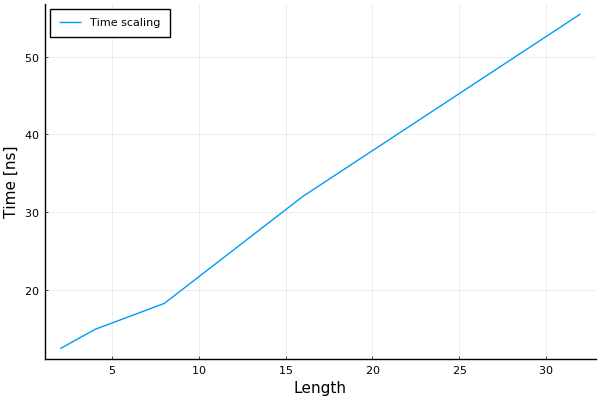

In [64]:
using BenchmarkTools

jmax = 5
jrange = 1:jmax
nvals = 2 .^ jrange
times = zeros(jmax)
for j in jrange
  X, kv = kv_array(nvals[j],rng)
  L = buildlist(kv)
  times[j] = median((@benchmark search($L,n) setup=(n=floor(Int64,$nvals[$j]*rand(rng)))).times)
end

plot(nvals,times,xlabel="Length",ylabel="Time [ns]",label="Time scaling")

## Question 2: Interval membership

The problem of interval membership is the following: given a set of contiguous intervals, 

$\left\{[x_0, x_1), [x_1, x_2), \ldots, [x_{n-2}, x_{n-1}), [x_{n-1}, x_n)\right\}$

spanning the interval $[x_1, x_n)$ and given a random number $x \in [x_1, x_n)$, determine the interval in which $x$ lies. The standard numerical algorithm for stochastic simulation of continuous-time Markov processes (eg birth-death process, contact process, SIR model etc) requires solving an interval membership problem at each time step. It is therefore important to be able to solve it efficiently. Note, we cannot assume that all intervals are the same length.

We can solve the interval membership problem with $n$ intervals by a variant of linear search in $O(n)$ time. 

**1)** Use Julia's random number generator to generate $n$ random interval lengths, $y_1, y_2, \ldots, y_n$ between 0 and 1. 
The corresponding interval membership problem is constructed from the partial sums:
$$x_i = \sum_{j=1}^i y_j, \ \ \ \ \ i=1,2,\ldots n.$$ 
Using the **KeyValuePair** and **LinkedList** objects defined in MA934.jl, create an array of key-value pairs, $(i, x_i)$, associating each interval with the corresponding partial sum and store this array in a linked list. Print the list for a small value of $n$ to verify that it works.

**2)** Modify the search function you wrote above to write a recursive function <br><br>
intervalmembership( L::Union{LinkedList, Nothing}, , x::Float64)<br><br>
that takes the **LinkedList**, L, containing the list of partial sums and a random **Float64** in the range $[0, x_n]$ as inputs and returns the **KeyValuePair** corresponding to the interval in which $x$ lies. Verify that it works for small values of $n$ and use BenchmarkTools.jl to measure how the typical computational cost grows with $n$. 

**3)** The file FenwickTree.jl defines a data structure implementing a variant of a Fenwick tree that can solve the interval membership problem as described in the lectures/notes. The function <br><br> 
buildFTree( dataArray::Array{KeyValuePair, 1} )<br><br>
takes the array of **KeyValuePair**s containing the *interval lengths* (**not** the partial sums) as input, recursively constructs the tree and returns the **FenwickTree** containing the correct key-value pairs (note a key of -1 is assigned to all non-leaf nodes). Here is an example:

In [122]:
n = 5
y = rand(rng,n)
x,kv = partial_sum_kv(n,y)
L = buildlist(kv)
print(L)

LinkedList(KeyValuePair(1, 0.8847141343931104), LinkedList(KeyValuePair(2, 1.380412276709682), LinkedList(KeyValuePair(3, 2.2770959642649835), LinkedList(KeyValuePair(4, 2.9105625143430824), LinkedList(KeyValuePair(5, 3.4606988689123153), nothing)))))

In [123]:
xi = rand(rng)*x[end]
ikv = intervalmembership(L,xi)
println(L,"\n",xi,"\n",ikv)

LinkedList(KeyValuePair(1, 0.8847141343931104), LinkedList(KeyValuePair(2, 1.380412276709682), LinkedList(KeyValuePair(3, 2.2770959642649835), LinkedList(KeyValuePair(4, 2.9105625143430824), LinkedList(KeyValuePair(5, 3.4606988689123153), nothing)))))
1.9669356843340862
KeyValuePair(3, 2.2770959642649835)


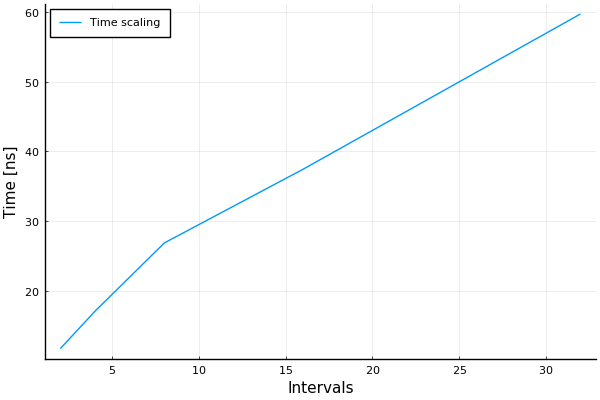

In [124]:
jmax = 5
jrange = 1:jmax
nvals = 2 .^ jrange
times = zeros(jmax)
for j in jrange
  y = rand(rng,nvals[j])
  x,kv = partial_sum_kv(nvals[j],y)
  L = buildlist(kv)
  times[j] = median((@benchmark intervalmembership($L,xi) setup=(xi=rand(rng)*$x[end])).times)
end
plot(nvals,times,xlabel="Intervals",ylabel="Time [ns]",label="Time scaling")

Write a recursive function<br><br>
intervalmembership(T::Union{FenwickTree, Nothing}, x::Float64)<br><br>
that takes the **FenwickTree** containing the list of partial sums and a random Float64 in the range $[0, x_n]$ as 
inputs and returns the **KeyValueVPair** corresponding to the interval in which $x$ lies. Verify that it works for small values of $n$ and use the BenchmarkTools macros to compare how the typical computational compares to the above linear search version. Note it can sometimes be difficult to directly measure $O(\log\, n)$ growth in computation time since the problem size needs to become very large to register appreciable run times.

In [125]:
n = 5
y, kv = kv_array(n,rng)
T = buildFTree(kv)
xi=rand(rng)*T.data.value
ikv = intervalmembership(T,xi)
println(xi,"\n",ikv)
println(sum(y[1:ikv.key]))

1.1972700517964068
KeyValuePair(3, 0.6453267819235717)
1.2123260761366441


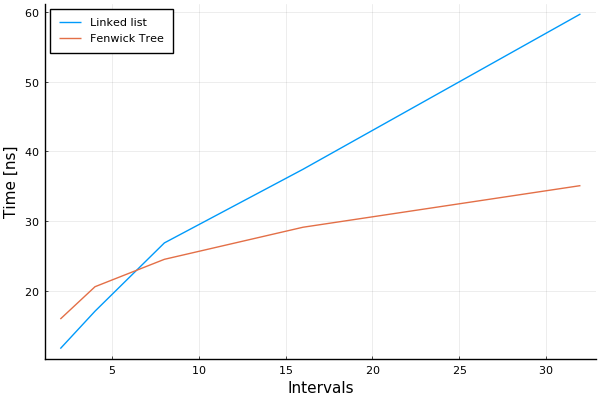

In [126]:
times_tree = zeros(jmax)
for j in jrange
  y,kv = kv_array(nvals[j],rng)
  T = buildFTree(kv)
  times_tree[j] = median((@benchmark intervalmembership($T,xi) setup=(xi=rand(rng)*$T.data.value)).times)
end
plot(nvals,times,xlabel="Intervals",ylabel="Time [ns]",label="Linked list")
plot!(nvals,times_tree,xlabel="Intervals",ylabel="Time [ns]",label="Fenwick Tree")

## Question 3: Gillespie algorithm for heterogeneous diffusion

The Gillespie algorithm is a dynamic Monte Carlo algorithm that generates statistically correct realisations of a continous time Markov process. See https://en.wikipedia.org/wiki/Gillespie_algorithm It is used heavily in stochastic simulation of chemical and biological reaction networks and population dynamics. In this question we use it to simulate one-dimensional diffusion of heterogeneous particles whose diffusion constants are independently drawn from an exponential distribution.

The basic idea of the algorithm is as follows
1. Create a list $\left\{(i, r_i), i=1,\ldots M\right\}$,  of all possible transitions (events), $i$, that can occur in the system and the corresponding transition rates, $r_i$.
2. Calculate the total rate
$$R = \sum_{i=1}^M r_i$$
and divide the interval $[0, R]$ into $M$ intervals whose lengths are given by the $r_i$.
3. Generate a uniform random number in the range $[0,R]$ and determine which interval it falls in. 
4. Perform the corresponding transition and update the time variable by an amount $\Delta t = 1/R$.
5. Repeat until the desired simulation time is reached.

To be concrete, suppose with have $N$ particles on the interval $[-L, L]$ initially located at $x=0$. Each particle can hop a distance $\Delta x$ to the left or to the right with equal probability. The rate of hopping is initially considered to be the same for all particles:

$$ r_i = \frac{D}{2}\,\frac{1}{(\Delta x)^2} $$

This choice ensures that in the continous limit ($\Delta x \to 0$, $N\to \infty$), the density of particles $c(x,t)$ on the line will satisfy the usual diffusion equation with diffusion coefficient $D$ (recall MA933):

$$ \frac{\partial c}{\partial t} = D \frac{\partial^2 c}{\partial x^2}$$

with initial condition $c(x,0) = \delta(x)$.

The steps of the algorithm then correspond to the following:
1. There are $M= 2 N$ possible transitions at each step: each of $N$ particles can hop a distance $\Delta x$ either left or right with the above rates. We index them as follows: events k=1:N correspond to particle k hopping to the right, events k=N+1:2N correspond to particle k-N hopping to the left.
2. The total rate is 
$$ R = \frac{D N}{(\Delta x)^2}.$$
3. Generate a uniform random number in the range $[0,R]$ and determine the index $k$ of particle to move and the direction.
4. Update the position of particle $k$ accordingly.
5. Repeat.

The following piece of code implements the Gillespie algorithm for N=100, L=10, $\Delta x = 0.1$ and $D=1$, converts the particle positions to particle density and compares to the solution of the diffusion equation on an unbounded domain at t=1 (we assume that L=10 is far enough from zero to be considered unbounded):

$$c(x, t) = \frac{1}{\sqrt{2 \pi D t}}\, \exp [-\frac{1}{2}\frac{x^2}{D t} ]$$

9999.999999999998


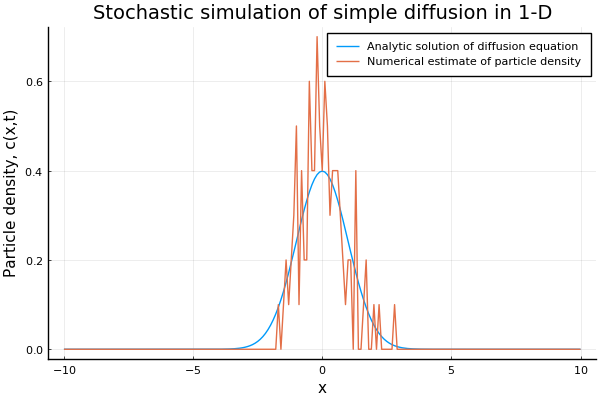

In [157]:
L=10.0
N=100
Nx = 201
dx = 2.0*L/(Nx-1)
X = dx.*(-(Nx-1)/2:(Nx-1)/2)
Y =zeros(Int64,N)
D = 1.0
t=0.0

r = (D/2.0)/(dx*dx)
totalRate = 2.0*N*r
dt = 1.0/totalRate
T=1.0

# This is the main loop
while t < T
    # Pick an event
    k = rand(1:2*N)
    if k<=N
        hop = 1
        particleId = k
    else
        hop = -1
        particleId=k-N
    end
    Y[particleId]+=hop
    t+=dt
end

# Calculate the estimated density of particles
P =zeros(Float64,length(X))
for i in 1:length(Y)
    P[Y[i]+Int64((Nx-1)/2)+1]+=1/(N * dx)
end

# Calculate the theoretical density and compare
function normal(x, D, t)
    return (1.0/sqrt(2.0*pi*D*t))*exp(-x*x/(2*D*t))
end
P1 = normal.(X, D, T)
plot(X, P1, label="Analytic solution of diffusion equation")
plot!(X, P, label="Numerical estimate of particle density")
xlabel!("x")
ylabel!("Particle density, c(x,t)")
title!("Stochastic simulation of simple diffusion in 1-D")

**1)** The code above makes critical use of the fact that all intervals have the same width in order to decide which particle to move at each step. Suppose now that instead of being equal to $D$ for each particle, the diffusion coefficients are drawn from an exponential distribution with mean $D$:

$$ P(x) = \frac{1}{D} \exp\left(-\frac{x}{D}\right). $$

Modify the code to account for this, using your code from Q2 above to solve the interval membership problem using linear search. You will need to use Julia's randexp() function to generate values for the diffusion coefficients. What is the largest value of $N$ you can simulate in a "reasonable" time?

**2)** Try again using your Fenwick tree from Q2 to solve the interval membership problem and compare. What is the largest value of $N$ you can simulate now?

**3)** Show analytically that the solution of the heterogenous diffusion problem is

$$ c(x,t) = \frac{\exp \left(-\sqrt{\frac{2}{D\,t}}\, |x| \right)}{\sqrt{2\, D\, t}}$$

You will probably need the integral formula (Formula 3.325 of Gradshteyn and Rizhik, 7th Ed.)

$$ \int_0^\infty \exp\left(-a\,x^2 - \frac{b}{x^2} \right)\, dx =  \frac{1}{2}\,\sqrt{\frac{\pi}{a}}\,\exp\left(-2 \sqrt{a\,b} \right).$$
Use this formula to validate your numerical results.



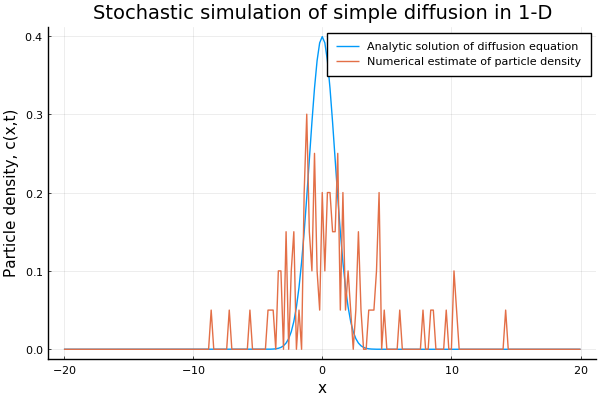

In [165]:
# Part 1
L=20.0
N=100
Nx = 201
dx = 2.0*L/(Nx-1)
X = dx.*(-(Nx-1)/2:(Nx-1)/2)
Y =zeros(Int64,N)
D = 1.0
t=0.0

# Calculate rates, drawing P(x) from exponential distribution
P = randexp(rng,2*N)
r = P./(2*dx*dx)
totalRate = sum(r)
dt = 1.0/totalRate
T=1.0

# Produce linked list of rate key value pairs
x,kv = partial_sum_kv(2*N,r)
L = buildlist(kv)

# This is the main loop
while t < T
    # Pick an event
    xi = rand(rng)*totalRate
    k = intervalmembership(L,xi)
    if k.key <= N
        hop = 1
        particleId = k.key
    else
        hop = -1
        particleId=k.key-N
    end
    Y[particleId]+=hop
    t+=dt
end

# Calculate the estimated density of particles
P =zeros(Float64,length(X))
for i in 1:length(Y)
    P[Y[i]+Int64((Nx-1)/2)+1]+=1/(N * dx)
end

# Calculate the theoretical density and compare
function normal(x, D, t)
    return (1.0/sqrt(2.0*pi*D*t))*exp(-x*x/(2*D*t))
end
P1 = normal.(X, D, T)
plot(X, P1, label="Analytic solution of diffusion equation")
plot!(X, P, label="Numerical estimate of particle density")
xlabel!("x")
ylabel!("Particle density, c(x,t)")
title!("Stochastic simulation of simple diffusion in 1-D")